### Считываем данные и делаем препроцессинг, в результате которого получаем списки коннектомов для контрольной группы и группы пациентов ###

In [1]:
import numpy as np
import pandas as pd
import pathlib as plib

In [2]:
data_path = plib.Path("./data/OASIS3/ts_extracted")

In [3]:
controls_path = data_path / "controls/AAL"
patients_path = data_path / "patients/AAL"

In [4]:
alzheimer_features = [
    "Hippocampus_L",
    "Hippocampus_R",
    "ParaHippocampal_L",
    "ParaHippocampal_R",
    "Cingulum_Ant_L",
    "Cingulum_Ant_R",
    "Cingulum_Mid_L",
    "Cingulum_Mid_R",
    "Cingulum_Post_L",
    "Cingulum_Post_R",
    "Amygdala_L",
    "Amygdala_R"
]

In [5]:
controls_connectomes = [np.corrcoef(pd.read_csv(table)[alzheimer_features].T) for table in controls_path.iterdir() if plib.Path(table).stat().st_size > 15 * 1024]
patients_connectomes = [np.corrcoef(pd.read_csv(table)[alzheimer_features].T) for table in patients_path.iterdir() if plib.Path(table).stat().st_size > 15 * 1024]

### Смотрим на устойчивые гомологии фильтрации Вьеториса-Рипса

Рассмотрим матрицу вида $(D)_{ij} = 1 - C_{ij},$ где $C$ - матрица коннектома, в качестве матрицы попарных расстояний на множестве точек. К каждой такой матрице применим фильтрацию Вьеториса-Рипса и построим для неё диаграмму устойчивости для гомологий размерности не более $2$.

In [6]:
import ripser
import matplotlib.pyplot as plt

In [7]:
rips = ripser.Rips(maxdim=2, verbose=False)
controls_vr_diagrams = []
patients_vr_diagrams = []

In [8]:
%%time
for C in controls_connectomes:
    D = 1 - C
    controls_vr_diagrams.append(rips.fit_transform(D, distance_matrix=True))

for C in patients_connectomes:
    D = 1 - C
    patients_vr_diagrams.append(rips.fit_transform(D, distance_matrix=True))

CPU times: user 310 ms, sys: 427 µs, total: 310 ms
Wall time: 308 ms


In [9]:
controls_vr_diagrams = np.array(controls_vr_diagrams)
patients_vr_diagrams = np.array(patients_vr_diagrams)

/tmp/ipykernel_196905/2347701106.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  controls_vr_diagrams = np.array(controls_vr_diagrams)
/tmp/ipykernel_196905/2347701106.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  patients_vr_diagrams = np.array(patients_vr_diagrams)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

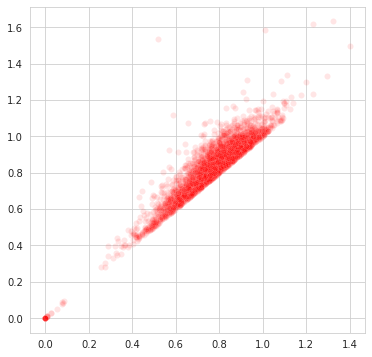

CPU times: user 14.9 s, sys: 163 ms, total: 15 s
Wall time: 14.8 s


In [11]:
%%time

plt.figure(figsize=(6, 6))
plt.grid(True)
for diagram in controls_vr_diagrams:
    sns.scatterplot(
        x=[x[0] for x in diagram[1]],
        y=[x[1] for x in diagram[1]], # 1-dimensional homologies
        alpha=0.1, color='red')
plt.show()

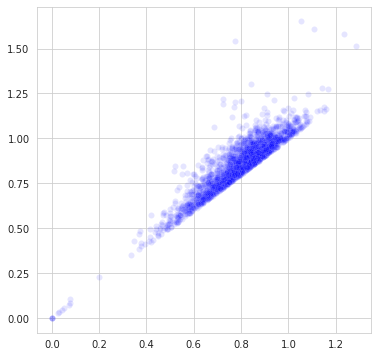

In [12]:
plt.figure(figsize=(6, 6))
plt.grid(True)
for diagram in patients_vr_diagrams:
    sns.scatterplot(
        x=[x[0] for x in diagram[1]],
        y=[x[1] for x in diagram[1]], # 1-dimensional homologies
        alpha=0.1, color='blue')
plt.show()

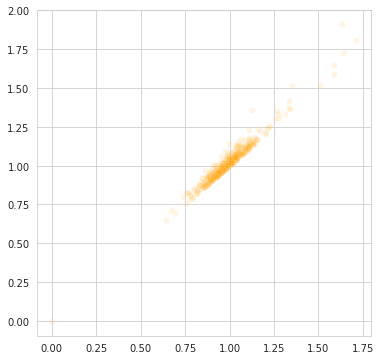

In [13]:
plt.figure(figsize=(6, 6))
plt.grid(True)
for diagram in controls_vr_diagrams:
    sns.scatterplot(
        x=[x[0] for x in diagram[2]],
        y=[x[1] for x in diagram[2]], # 2-dimensional homologies
        alpha=0.1, color='orange')
plt.show()

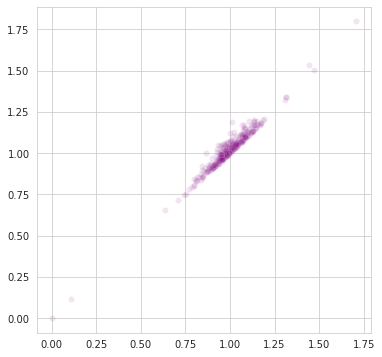

In [14]:
plt.figure(figsize=(6, 6))
plt.grid(True)
for diagram in patients_vr_diagrams:
    sns.scatterplot(
        x=[x[0] for x in diagram[2]],
        y=[x[1] for x in diagram[2]], # 2-dimensional homologies
        alpha=0.1, color='purple')
plt.show()

Разобьём часть квадрата выше прямой $y = x$ на квадратики размера $1/d \times 1/d,$ для каждого маленького квадратика посчитаем число точек диаграммы устойчивости в нём, получим вектор признаков из $2d^2 + 3d$ чисел.

In [15]:
d = 30
bins_left = np.arange(0, 2 * d)

In [16]:
bins = []
for l in bins_left:
    for r in np.arange(l, 2 * d + 1, 1):
        bins.append((l / d, r / d))

In [17]:
len(bins)

1890

In [18]:
bin_to_id = dict()
for i in range(len(bins)):
    bin_to_id[bins[i]] = i

In [19]:
controls_vectors = []
for diagram in controls_vr_diagrams:
    vec = np.zeros((len(bins)))
    for point in diagram[1]:
        x, y = int(point[0] * d) / d, int(point[1] * d) / d
        vec[bin_to_id[(x, y)]] += 1
    for point in diagram[2]:
        x, y = int(point[0] * d) / d, int(point[1] * d) / d
        vec[bin_to_id[(x, y)]] += 1
    controls_vectors.append(vec)
controls_vectors = np.array(controls_vectors)

In [20]:
patients_vectors = []
for diagram in patients_vr_diagrams:
    vec = np.zeros((len(bins)))
    for point in diagram[1]:
        x, y = int(point[0] * d) / d, int(point[1] * d) / d
        vec[bin_to_id[(x, y)]] += 1
    for point in diagram[2]:
        x, y = int(point[0] * d) / d, int(point[1] * d) / d
        vec[bin_to_id[(x, y)]] += 1
    patients_vectors.append(vec)
patients_vectors = np.array(patients_vectors)

In [21]:
X = np.concatenate((controls_vectors, patients_vectors), axis=0)
y = np.zeros(len(X))
y[len(controls_vectors):] = 1
np.random.seed(57)
np.random.shuffle(X)
np.random.seed(57)
np.random.shuffle(y)

Обучим простые модели на построенных таким образом векторах и посчитаем leave-one-out скор на всём датасете:

In [22]:
from sklearn.model_selection import LeaveOneOut

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [23]:
n_neighbors_variants = [1, 3, 5, 11, 21, 31, 51, 71, 101, 151, 201]

In [24]:
%%time

for n_neighbors in n_neighbors_variants:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    score = 0
    for train_index, test_index in LeaveOneOut().split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        score += clf.predict(X_test) == y_test
    print("KNN leave-one-out accuracy for {} neighbors on persistance diagrams discretization:".format(n_neighbors), score / len(X))

KNN leave-one-out accuracy for 1 neighbors on persistance diagrams discretization: [0.51848341]
KNN leave-one-out accuracy for 3 neighbors on persistance diagrams discretization: [0.53175355]
KNN leave-one-out accuracy for 5 neighbors on persistance diagrams discretization: [0.57109005]
KNN leave-one-out accuracy for 11 neighbors on persistance diagrams discretization: [0.58009479]
KNN leave-one-out accuracy for 21 neighbors on persistance diagrams discretization: [0.57156398]
KNN leave-one-out accuracy for 31 neighbors on persistance diagrams discretization: [0.60900474]
KNN leave-one-out accuracy for 51 neighbors on persistance diagrams discretization: [0.60995261]
KNN leave-one-out accuracy for 71 neighbors on persistance diagrams discretization: [0.61563981]
KNN leave-one-out accuracy for 101 neighbors on persistance diagrams discretization: [0.61421801]
KNN leave-one-out accuracy for 151 neighbors on persistance diagrams discretization: [0.61374408]
KNN leave-one-out accuracy for 

In [25]:
%%time

clf = LogisticRegression(max_iter=500)
score = 0
for train_index, test_index in LeaveOneOut().split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    score += clf.predict(X_test) == y_test
print("LogReg leave-one-out accuracy on persistance diagrams discretization:", score / len(X))

LogReg leave-one-out accuracy on persistance diagrams discretization: [0.58341232]
CPU times: user 1h 1min 46s, sys: 30min 34s, total: 1h 32min 20s
Wall time: 7min 57s


In [26]:
%%time

clf = SVC()
score = 0
for train_index, test_index in LeaveOneOut().split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    score += clf.predict(X_test) == y_test
print("Support vector classifier leave-one-out accuracy on persistance diagrams discretization:", score / len(X))

Support vector classifier leave-one-out accuracy on persistance diagrams discretization: [0.60379147]
CPU times: user 2h 14s, sys: 3.32 s, total: 2h 18s
Wall time: 2h 17s


### Строим базис пространства циклов и проецируем графы (векторы весов рёбер графов) объектов на это пространство, используем проекции как векторы признаков для обучения

Рассмотрим все рёбра, которые не попали в максимальное остовное дерево. Таких рёбер в полном графе ровно $$\frac{n(n - 1)}{2} - n + 1 = \frac{(n - 1)(n - 2)}{2}.$$

Каждое такое ребро при добавлении к максимальному остовному дереву порождает ровно один цикл, который является представителем своего класса $1$-мерных гомологий полного графа (поскольку мы не рассматриваем грани размерности выше $1$).

Для каждого ребра не из максимального остовного дерева возьмём вектор в пространстве линейных комбинаций рёбер графа, который соответствует циклу, порождённому этим ребром (этот вектор равен знакочередующейся сумме рёбер.  Всего такие векторы линейно независимы и составляют базис пространства циклов, которое является подпространством размерности $\frac{(n - 1)(n - 2)}{2}$ пространства линейных комбинаций рёбер (пространстве цепей размерности $1$), размерность которого составляет $\frac{n(n - 1)}{2}$.

Переберём все рёбра, не входящие в максимальный остов графа ```D_mean```, и для каждого ребра построим вектор, соответствующий циклу, который порождается добвлением этого ребра к остову. Таким образом, мы построим базис пространства циклов. Далее, будем представлять каждый коннектом из выборки как вектор весов рёбер (длины $n(n - 1) / 2$) и проецировать этот вектор на пространство циклов, а также находить разложение этой проекции по построенному нами выше базису пространства циклов.

У описанной процедуры есть простая геометрическая интерпретация: если для данного коннектома в разложении его проекции по базису коэффициент при каком-то цикле большой, то данный цикл хорошо выражен в данном коннектоме.

Предлагается использовать полученные разложения проекций коннектомов по построенному базису в виде векторов признаков для обучения моделей классификации.

### Алгоритм:

Находим поэлементное среднее матриц коннектомов всех объектов выборки (например, из группы пациентов):  

In [27]:
D_mean = 1 - np.mean(patients_connectomes, axis=0)

Напишем функцию, которая строит максимальное остовное дерево в графе алгоритмом Прима:

In [28]:
import typing as tp

In [29]:
def CalcMaxSpanningTreeEdgesSet(D: np.array) -> tp.List[tp.Tuple[int, int]]:
    """
    С помощью алгоритма Прима находим
    максимальное по весу остовное дерево в графе,
    который задан матрицей смежности D.
    
    Возвращаем список рёбер (пар вершин), 
    которые входят в максимальное остовное дерево.
    """
    n = len(D)
    assert D.shape == (n, n)
    
    dist = D[0].copy()
    prev = np.zeros(n)
        
    max_spanning_tree_edges = []
    
    for step in range(1, n):
        max_dist = None
        argmax = None
        for i in range(1, n):
            if dist[i] and (max_dist is None or max_dist < dist[i]):
                max_dist = dist[i]
                argmax = i
                
        p = int(prev[argmax])
                
        max_spanning_tree_edges.append((min(argmax, p), max(argmax, p)))
        dist[argmax] = 0
        
        for i in range(1, n):
            if dist[i] and dist[i] < D[argmax][i]:
                dist[i] = D[argmax][i]
                prev[i] = argmax
                
    max_spanning_tree_edges.sort()
    return max_spanning_tree_edges

Находим максимальное остовное дерево для среднего матриц коннектомов по контрольной группе:

In [30]:
%%time
D_mean_MaxST = CalcMaxSpanningTreeEdgesSet(D_mean)

CPU times: user 77 µs, sys: 29 µs, total: 106 µs
Wall time: 105 µs


По полученному набору рёбер остовного дерева построим матрицу смежности и списки смежности этого дерева (как невзвешенного графа).

In [31]:
D_mean_MaxST_adj_lists = [[] for i in range(len(D_mean))]
D_mean_MaxST_adj_matrix = np.zeros(D_mean.shape)

for edge in D_mean_MaxST:
    D_mean_MaxST_adj_lists[edge[0]].append(edge[1])
    D_mean_MaxST_adj_lists[edge[1]].append(edge[0])
    D_mean_MaxST_adj_matrix[edge[0]][edge[1]] = 1
    D_mean_MaxST_adj_matrix[edge[1]][edge[0]] = 1

Напишем несколько вспомогательных функций:

In [32]:
def Dfs(v: int, parent: tp.List[int], adj_lists: tp.List[tp.List[int]]) -> None:
    """
    Делаем обход дерева в глубину,
    при этом в массиве parent для каждой вершины
    сохраняем номер её предка. 
    """
    p = parent[v]
    for u in adj_lists[v]:
        if u != p:
            parent[u] = v
            Dfs(u, parent, adj_lists)
            

def GetEdgeNum(u: int, v: int, n: int) -> int:
    """
    Получаем по паре вершин u, v и общему числу вершин в графе n
    номер ребра (u, v) в графе
    (от 0 до n * (n - 1) // 2 - 1 включительно).
    """
    u, v = min(u, v), max(u, v)                 
    return u * (n * 2 - 1 - u) // 2 + v - u - 1

    
def GetPath(s: int, t: int, adj_lists: tp.List[tp.List[int]]) -> tp.List[int]:
    """
    Находим в дереве, которое задаётся списками смежности adj_lists,
    путь от вершины s до вершины t и возвращаем список вершин на этом пути.
    """
    parent = [-1] * len(adj_lists)
    Dfs(s, parent, adj_lists)
    path = []
    while t != s:
        path.append(t)
        t = parent[t]
    path.append(s)
    return path

Строим векторы, соответствующие циклам:

In [33]:
%%time

n = len(D_mean)
n_edges = n * (n - 1) // 2
cycle_eigenvectors = []

for i in range(n):
    for j in range(i + 1, n):
        if not D_mean_MaxST_adj_matrix[i, j]:
            cycle_eigenvector = np.zeros(n_edges)
            path = GetPath(i, j, D_mean_MaxST_adj_lists)
            for k in range(len(path)):
                cur, nxt = path[k], path[(k + 1) % len(path)]
                edge_index = GetEdgeNum(cur, nxt, n)
                cycle_eigenvector[edge_index] = 1 # if cur < nxt else -1 
                                                  # разные варианты понимания того,
                                                  # как выглядит вектор, соответствующий циклу:
                                                  # выбирать знаки рёбер так, чтобы действительно 
                                                  # получался собственный вектор 1-го лапласиана Ходжа,
                                                  # или просто всем рёбрам на цикле дать вес 1
                                                  #
                                                  # не сильно отличаются на практике
            cycle_eigenvector /= np.sqrt(len(path))
            cycle_eigenvectors.append(cycle_eigenvector)
            assert np.abs(cycle_eigenvector @ cycle_eigenvector - 1) < 0.0000001
            
cycle_eigenvectors = np.array(cycle_eigenvectors).T

CPU times: user 786 µs, sys: 297 µs, total: 1.08 ms
Wall time: 1.13 ms


Находим проекции $\pi_С(v_i),\ i = 1, \ldots, N$ (где $N$ - число объектов в выборке, $v_i$ - вектор весов рёбер для $i$-го объекта выборки) на пространство циклов $C$ по формуле
$$\pi_C(v) = C(C^TC)^{-1}C^Tv.$$

Нас интересуют именно коэффициенты в разложении $\pi_C(v)$ по базису из циклов, то есть, из столбцов матрицы $C$. Вектор этих коэфициентов, соответственно, находится по формуле $(C^TC)^{-1}C^Tv$.

Для начала строим матрицу проекции $\mathrm{Proj} = (C^TC)^{-1}C^T$:

In [34]:
import scipy.linalg

In [35]:
%%time
proj_matrix = scipy.linalg.inv(cycle_eigenvectors.T @ cycle_eigenvectors) @ cycle_eigenvectors.T

CPU times: user 849 µs, sys: 321 µs, total: 1.17 ms
Wall time: 2.47 ms


Напишем функцию для перевода объектов из представления в виде матрицы коннектома в представление в виде вектора весов рёбер (эквивалентно, делаем ```flatten()``` для части матрицы коннектома выше главной диагонали): 

In [36]:
def TransformConnectomeToEdgeVector(C: np.array) -> np.array:
    n = len(C)
    assert C.shape == (n, n)
    
    n_edges = n * (n - 1) // 2
    edge_vector = np.ones(n_edges)
    
    l = 0
    for i in range(n):
        edge_vector[l:l + n - i - 1] -= C[i, i + 1:]
        l += n - i - 1
    return edge_vector

Находим разложения по базису циклов для проекций коннектомов из контрольной группы:

In [37]:
controls_edge_vectors = []
for C in controls_connectomes:
    controls_edge_vectors.append(TransformConnectomeToEdgeVector(C))
    
controls_edge_vectors = np.array(controls_edge_vectors).T

In [38]:
controls_cycle_projections = proj_matrix @ controls_edge_vectors
controls_cycle_projections = controls_cycle_projections.T # чтобы получить матрицу размера N_controls x ((n - 1)(n - 2)/2)

In [39]:
controls_cycle_projections.shape

(1295, 55)

Проделаем то же самое для коннектомов из группы пациентов:

In [40]:
patients_edge_vectors = []
for C in patients_connectomes:
    patients_edge_vectors.append(TransformConnectomeToEdgeVector(C))
    
patients_edge_vectors = np.array(patients_edge_vectors).T

In [41]:
patients_cycle_projections = proj_matrix @ patients_edge_vectors
patients_cycle_projections = patients_cycle_projections.T # чтобы получить матрицу размера N_patients x ((n - 1)(n - 2)/2)

Строим датасет на полученных признаках для обучения (```X```, ```y```):

In [42]:
X = np.concatenate((controls_cycle_projections, patients_cycle_projections), axis=0)
y = np.zeros(len(X))
y[len(controls_cycle_projections):] = 1
np.random.seed(57)
np.random.shuffle(X)
np.random.seed(57)
np.random.shuffle(y)

Также построим датасет на векторизованных исходных матрицах коннектомов (```X_raw```, ```y_raw```):

In [43]:
patients_edge_vectorsT = patients_edge_vectors.T
controls_edge_vectorsT = controls_edge_vectors.T

X_raw = np.concatenate((controls_edge_vectorsT, patients_edge_vectorsT), axis=0)
y_raw = np.zeros(len(X_raw))
y_raw[len(controls_edge_vectorsT):] = 1
np.random.seed(57)
np.random.shuffle(X)
np.random.seed(57)
np.random.shuffle(y)

Пытаемся обучить KNN и сравнить качество на проекциях на циклы vs векторизованных исходных матрицах коннектомов:

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

In [45]:
n_neighbors_variants = [1, 3, 5, 11, 21, 31, 51, 71, 101, 151, 201]

In [46]:
%%time
# проекции на циклы, KNN
for n_neighbors in n_neighbors_variants:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    score = 0
    for train_index, test_index in LeaveOneOut().split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        score += clf.predict(X_test) == y_test
    print("KNN leave-one-out accuracy for {} neighbors on cycle projections:".format(n_neighbors), score / len(X))

KNN leave-one-out accuracy for 1 neighbors on cycle projections: [0.55734597]
KNN leave-one-out accuracy for 3 neighbors on cycle projections: [0.55876777]
KNN leave-one-out accuracy for 5 neighbors on cycle projections: [0.56919431]
KNN leave-one-out accuracy for 11 neighbors on cycle projections: [0.59194313]
KNN leave-one-out accuracy for 21 neighbors on cycle projections: [0.60758294]
KNN leave-one-out accuracy for 31 neighbors on cycle projections: [0.61232227]
KNN leave-one-out accuracy for 51 neighbors on cycle projections: [0.62085308]
KNN leave-one-out accuracy for 71 neighbors on cycle projections: [0.61800948]
KNN leave-one-out accuracy for 101 neighbors on cycle projections: [0.62843602]
KNN leave-one-out accuracy for 151 neighbors on cycle projections: [0.62606635]
KNN leave-one-out accuracy for 201 neighbors on cycle projections: [0.62322275]
CPU times: user 1min 49s, sys: 4min 48s, total: 6min 37s
Wall time: 33.3 s


Сравним с обучением на непосредственно векторизованных матрицах коннектомов:

In [47]:
%%time
# векторизованные матрицы коннектомов, KNN
for n_neighbors in n_neighbors_variants:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    score = 0
    for train_index, test_index in LeaveOneOut().split(X_raw):
        X_train, X_test = X_raw[train_index], X_raw[test_index]
        y_train, y_test = y_raw[train_index], y_raw[test_index]
        clf.fit(X_train, y_train)
        score += clf.predict(X_test) == y_test
    print("KNN leave-one-out accuracy for {} neighbors on vectorized connectomes:".format(n_neighbors), score / len(X))

KNN leave-one-out accuracy for 1 neighbors on vectorized connectomes: [0.57393365]
KNN leave-one-out accuracy for 3 neighbors on vectorized connectomes: [0.57251185]
KNN leave-one-out accuracy for 5 neighbors on vectorized connectomes: [0.59905213]
KNN leave-one-out accuracy for 11 neighbors on vectorized connectomes: [0.61137441]
KNN leave-one-out accuracy for 21 neighbors on vectorized connectomes: [0.63033175]
KNN leave-one-out accuracy for 31 neighbors on vectorized connectomes: [0.62132701]
KNN leave-one-out accuracy for 51 neighbors on vectorized connectomes: [0.63175355]
KNN leave-one-out accuracy for 71 neighbors on vectorized connectomes: [0.63033175]
KNN leave-one-out accuracy for 101 neighbors on vectorized connectomes: [0.62748815]
KNN leave-one-out accuracy for 151 neighbors on vectorized connectomes: [0.63459716]
KNN leave-one-out accuracy for 201 neighbors on vectorized connectomes: [0.63033175]
CPU times: user 2min 3s, sys: 5min 21s, total: 7min 24s
Wall time: 37.2 s


Сравним на линейных моделях:

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [49]:
%%time
# проекции на циклы, LogReg
clf = LogisticRegression(max_iter=500)

score = 0
for train_index, test_index in LeaveOneOut().split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    score += clf.predict(X_test) == y_test
print(score / len(X))

[0.61421801]
CPU times: user 6min 36s, sys: 13min 10s, total: 19min 47s
Wall time: 1min 39s


In [50]:
%%time
# векторизованные исходные матрицы, LogReg
clf = LogisticRegression(max_iter=500)

score = 0
for train_index, test_index in LeaveOneOut().split(X_raw):
    X_train, X_test = X_raw[train_index], X_raw[test_index]
    y_train, y_test = y_raw[train_index], y_raw[test_index]
    clf.fit(X_train, y_train)
    score += clf.predict(X_test) == y_test
print(score / len(X))

[0.61800948]
CPU times: user 8min 37s, sys: 16min 37s, total: 25min 14s
Wall time: 2min 6s


In [51]:
%%time
# проекции на циклы, Support vector classifier
clf = SVC()

score = 0
for train_index, test_index in LeaveOneOut().split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    score += clf.predict(X_test) == y_test
print(score / len(X))

[0.62037915]
CPU times: user 5min 50s, sys: 757 ms, total: 5min 51s
Wall time: 5min 50s


In [52]:
%%time
# векторизованные исходные матрицы, Support vector classifier
clf = SVC()

score = 0
for train_index, test_index in LeaveOneOut().split(X_raw):
    X_train, X_test = X_raw[train_index], X_raw[test_index]
    y_train, y_test = y_raw[train_index], y_raw[test_index]
    clf.fit(X_train, y_train)
    score += clf.predict(X_test) == y_test
print(score / len(X))

[0.65023697]
CPU times: user 5min 16s, sys: 14 ms, total: 5min 16s
Wall time: 5min 16s
